<a href="https://colab.research.google.com/github/vietsub00/Perceiver_Notebook/blob/main/Perceiver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons
!pip install einops

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [2]:
import numpy as np
from math import pi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from einops import rearrange, repeat

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.106.205.146:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.106.205.146:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Setup Hyperparameters:

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
num_classes = 10
img_size = 32               
data_dim = img_size**2      # shape of the image after flatten out
input_axis = 2              # input axis 1 for audio/sequence data, 2 for image and 3 for 3D and/or video
input_channels = 3          # number of input channels: 3 for RGB image
num_freq_bands = 15          # number of freq bands, with original value (2 * K + 1)
max_freq = 50.0             # maximum frequency, hyperparameter depending on how fine the data is
batch_size = 256
num_epochs = 150     
ffn_dropout_rate = 0.0      # dropout rate for feed forward network
attn_dropout_rate = 0.0     # dropout rate for cross attention module
latent_dim = 256      # Size of the latent array.
projection_dim = (input_axis * (num_freq_bands * 2 + 1)) + input_channels   # Embedding size of each element in the data and latent arrays.
num_heads = 6         # Number of Transformer heads.
num_transformer_blocks = 6
num_iterations = 8    # Repetitions of the cross-attention and Transformer modules.
ffn_units = [
    projection_dim,
    projection_dim,
    ]                 # Size of the Transformer Feedforward network.
classifier_units = [
    projection_dim,
    num_classes,
]                      # Size of the Feedforward network of the final classifier.

## Load and apply Fourier encoding on the data:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_train shape: {x_test.shape}, y_train shape: {y_test.shape}')

x_train = x_train / 255
x_test = x_test / 255

170508288/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
x_train shape: (10000, 32, 32, 3), y_train shape: (10000, 1)


In [ ]:
def fourier_encode(x, max_freq, num_bands = 4):
  x = tf.expand_dims(x, -1)
  orig_x = x

  scales = tf.linspace(1., max_freq / 2, num_bands)
  scales = scales[(*((None,) * (len(x.shape) - 1)), Ellipsis)]

  x = x * scales * pi
  x = tf.concat([tf.sin(x), tf.cos(x)], axis = -1)
  x = tf.concat((x, orig_x), axis = -1)
  return x

In [ ]:
b, *axis, _ = x_train.shape

axis_pos = list(map(lambda size: tf.linspace(-1.0, 1.0, num = size), axis))
pos = tf.stack(tf.meshgrid(*axis_pos, indexing = "ij"), axis = -1)
enc_pos = fourier_encode(pos, max_freq, num_freq_bands)
enc_pos = rearrange(enc_pos, "... n d -> ... (n d)")
enc_pos = repeat(enc_pos, "... -> b ...", b = b)

x_train = tf.concat((x_train, enc_pos), axis = -1)
x_train = rearrange(x_train, "b ... d -> b (...) d")
print(x_train.shape)

(50000, 1024, 65)


In [9]:
from sklearn.model_selection import train_test_split

## Helper Functions:

In [ ]:
def feed_forward(hidden_units, activation='relu', use_bias=True, dropout_rate=0.0, name=None):
    ffn = []

    for units in hidden_units[:-1]:
        ffn.append(layers.Dense(units, activation=activation, use_bias=use_bias))

    ffn.append(layers.Dense(units=hidden_units[-1], use_bias=use_bias))
    ffn.append(layers.Dropout(dropout_rate))

    ffn = tf.keras.Sequential(ffn, name=name)
    return ffn

### Cross-attention module
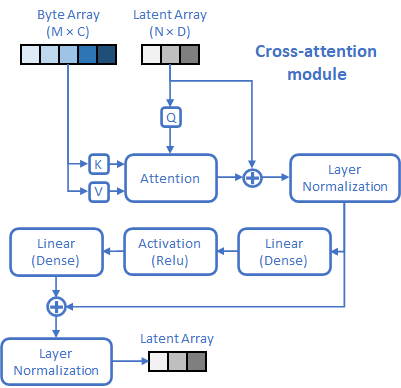
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
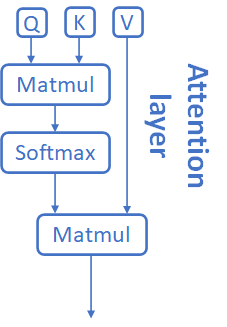

#### we should consider adding input channels instead of projection dimension for the byte array 

In [ ]:
def cross_attention_module(latent_dim, 
                           data_dim, 
                           projection_dim, 
                           ffn_units, 
                           ffn_dropout_rate = 0,
                           attn_dropout_rate = 0
):
    ''' According to the paper, the latent array has shape (N, D), which 
    corresponding to shape (latent_dim, projection_dim) in this function'''

    inputs = {
        # Recieve the latent array as an input of shape [1, latent_dim, projection_dim].
        "latent_array": layers.Input(shape=(latent_dim, projection_dim)),
        # Recieve the data_array (encoded image) as an input of shape [batch_size, data_dim, projection_dim].
        "data_array": layers.Input(shape=(data_dim, projection_dim))
    }

    # Apply layer norm to the inputs
    latent_array = layers.LayerNormalization(epsilon=1e-6)(inputs["latent_array"])
    data_array = layers.LayerNormalization(epsilon=1e-6)(inputs["data_array"])

    # Create query tensor: [1, latent_dim, projection_dim].
    query = layers.Dense(units=projection_dim)(latent_array)
    # Create key tensor: [batch_size, data_dim, projection_dim].
    key = layers.Dense(units=projection_dim)(data_array)
    # Create value tensor: [batch_size, data_dim, projection_dim].
    value = layers.Dense(units=projection_dim)(data_array)

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attn_output = layers.Attention(use_scale=True, dropout=attn_dropout_rate)(
        [query, key, value], return_attention_scores=False
    )
    # Skip connection 1.
    attn_output = layers.Add()([attn_output, latent_array])
    # Apply layer norm.
    attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output)
    # Apply Feedforward network.
    ffn_output = feed_forward(hidden_units=ffn_units, dropout_rate=ffn_dropout_rate)(attn_output)
    # Skip connection 2.
    ffn_output = layers.Add()([ffn_output, attn_output])
    # Apply layer norm.
    outputs = layers.LayerNormalization(epsilon=1e-6)(attn_output)

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='CrossAttention')
    return model

### Latent Transformer module

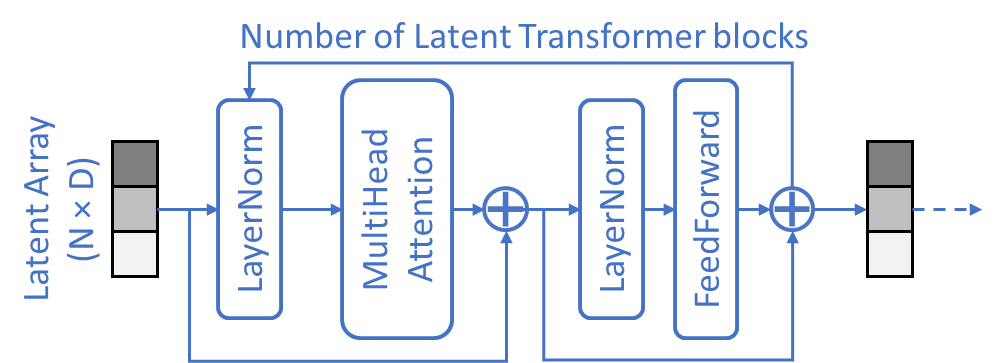

In [ ]:
def latent_transformer_module(latent_dim,
                              projection_dim,
                              num_heads,
                              num_transformer_blocks,
                              ffn_units,
                              ffn_dropout_rate = 0,
                              attn_dropout_rate = 0
):

    # input_shape: [1, latent_dim, projection_dim]
    inputs = layers.Input(shape=(latent_dim, projection_dim))

    x0 = inputs
    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        # Apply layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x0)
        # Create a multi-head self-attention layer.
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, 
                                                key_dim=projection_dim, 
                                                dropout=attn_dropout_rate)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attn_output, x0])
        # Apply layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # Apply Feedforward network.
        x3 = feed_forward(hidden_units=ffn_units, dropout_rate=ffn_dropout_rate)(x3)
        # Skip connection 2.
        x0 = layers.Add()([x3, x2])

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=x0, name='LatentTransformer')
    return model

## Perceiver class

In [ ]:
class Perceiver(tf.keras.Model):
    def __init__(
        self,
        data_dim,
        latent_dim,
        projection_dim,
        num_heads,
        num_transformer_blocks,
        ffn_units,
        ffn_dropout_rate,
        attn_dropout_rate,
        num_iterations,
        classifier_units
    ):
        super(Perceiver, self).__init__()

        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.ffn_units = ffn_units
        self.ffn_dropout_rate = ffn_dropout_rate
        self.attn_dropout_rate = attn_dropout_rate
        self.num_iterations = num_iterations
        self.classifier_units = classifier_units

        # Create latent array with shape [latent_dim, projection_dim], or (N, D) according to the paper
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer="random_normal", # we can change the initializer here
            trainable=True,
        )

        # Create global average pooling layer.
        self.global_average_pooling = layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = feed_forward(hidden_units=self.classifier_units, 
                                                dropout_rate=self.ffn_dropout_rate, name='to_logits')
        
        self.stacks = []
        for _ in range(self.num_iterations):
          self.stacks.append([cross_attention_module(self.latent_dim,
                                                     self.data_dim,
                                                     self.projection_dim,
                                                     self.ffn_units,
                                                     self.ffn_dropout_rate,
                                                     self.attn_dropout_rate
                                                     ), 
                              latent_transformer_module(self.latent_dim,
                                                        self.projection_dim,
                                                        self.num_heads,
                                                        self.num_transformer_blocks,
                                                        self.ffn_units,
                                                        self.ffn_dropout_rate,
                                                        self.attn_dropout_rate
                                                        )])

    def call(self, input):
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": tf.expand_dims(self.latent_array, 0),
            "data_array": input,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for stack in self.stacks:
            # Apply cross-attention between the latent array and the data array.
            latent_array = stack[0](cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = stack[1](latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        average = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(average)
        return logits

## Create model:

In [ ]:
with strategy.scope():
  model = Perceiver(data_dim,
                    latent_dim,
                    projection_dim,
                    num_heads,
                    num_transformer_blocks,
                    ffn_units,
                    ffn_dropout_rate,
                    attn_dropout_rate,
                    num_iterations,
                    classifier_units)
  model.compile(optimizer=tfa.optimizers.LAMB(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc"),
                         tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")]
                )

#model.summary()

In [ ]:
# Create a learning rate scheduler callback (reduce the learning rate when val_loss is not improve after 5 epochs: new_lr=lr*factor,)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.3, patience=5
)

# Create an early stopping callback. (Stop the training if the val_loss does not improve after 20 epochs)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)

In [ ]:
with strategy.scope():
  history = model.fit(x=x_train,
                      y=y_train,
                      batch_size=512,
                      epochs=200, 
                      #callbacks=[reduce_lr, early_stopping],
                      #validation_split=0.2
                      )

Epoch 1/200
98/98 [==============================] - 584s 2s/step - loss: 2.3002 - acc: 0.1510 - top5-acc: 0.6238
Epoch 2/200
98/98 [==============================] - 47s 477ms/step - loss: 2.0817 - acc: 0.2191 - top5-acc: 0.7365
Epoch 3/200
98/98 [==============================] - 47s 479ms/step - loss: 1.9893 - acc: 0.2580 - top5-acc: 0.7826
Epoch 4/200
98/98 [==============================] - 47s 478ms/step - loss: 1.9693 - acc: 0.2729 - top5-acc: 0.7926
Epoch 5/200
98/98 [==============================] - 47s 477ms/step - loss: 1.8898 - acc: 0.3008 - top5-acc: 0.8228
Epoch 6/200
98/98 [==============================] - 47s 478ms/step - loss: 1.7985 - acc: 0.3368 - top5-acc: 0.8484
Epoch 7/200
98/98 [==============================] - 47s 477ms/step - loss: 1.7435 - acc: 0.3620 - top5-acc: 0.8628
Epoch 8/200
98/98 [==============================] - 47s 479ms/step - loss: 1.7038 - acc: 0.3815 - top5-acc: 0.8724
Epoch 9/200
98/98 [==============================] - 47s 478ms/step - loss

In [ ]:
model.summary()

Model: "perceiver_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling1d_1   multiple                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 to_logits (Sequential)      (None, 10)                4950      
                                                                 
 CrossAttention (Functional)  (None, 256, 65)          13391     
                                                                 
 LatentTransformer (Function  (None, 256, 65)          668850    
 al)                                                             
                                                                 
 CrossAttention (Functional)  (None, 256, 65)          13391     
                                                                 
 LatentTransformer (Function  (None, 256, 65)          

In [ ]:
np.save('history_512batchsize_.npy', history.history)

In [3]:
history=np.load('history_512batchsize_.npy',allow_pickle='TRUE').item()

In [ ]:
from google.colab import files
files.download('history_512batchsize_.npy')

In [6]:
history.keys()

dict_keys(['loss', 'acc', 'top5-acc'])

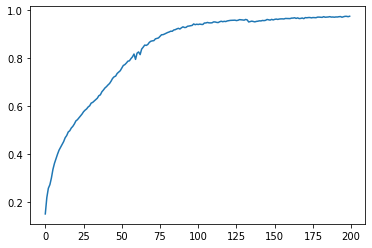

In [8]:
import matplotlib.pyplot as plt
plt.plot(history['acc'])